# Image Recognition - Emergency Vehicle

In this project, we will be delving into the realm of neural networks and their ability to recognize images of emergency vehicles. Imagine a world where a smart CCTV or a traffic light system can autonomously identify emergency vehicles such as police cars, fire trucks, and ambulances, and dynamically adjust traffic signals or alarm road traffic accordingly. This project aims to provide a Proof-of-Concept (POC) of one of the common techniques used in such scenarios.

We are working with a dataset comprising 681 images of emergency vehicles and 965 images of non-emergency vehicles. By leveraging the power of neural networks, we will explore how to teach a computer to accurately classify and distinguish between these two classes of vehicles - **Emergency vehicle** versus **Non-Emergency vehicle**.

The task at hand is not only intellectually stimulating but also highly practical in today's world, where advanced technology is increasingly being deployed to automate various processes. By developing an effective model that can recognize emergency vehicles, we can contribute to improving the efficiency and safety of traffic management systems.

# 1. Import Libraries

In [1]:
import torch
import torchvision
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt

C:\Users\asust\anaconda3\envs\PytorchCudaEnv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 2. Setting up the Environment

*In this section, we need to establish the specific hyperparameters that will govern the experiment's execution.*

- **number of epochs** - hyperparameter which determines the number of times we will iterate over the complete training dataset.
- **batch_size** - specifies the number of training examples processed together in each iteration,
- **learning_rate** - hyperparameter which influences the step size taken during the optimization process. It determines how quickly the model adjusts its parameters in response to the training data. A higher learning rate can lead to faster convergence, but it runs the risk of overshooting or oscillating around the optimal solution. Conversely, a lower learning rate may result in slower convergence or getting stuck in suboptimal solutions. 
- **momentum** - hyperparameter which helps accelerate convergence by accumulating the previous gradients' effect and smoothing out irregular updates. Setting an appropriate momentum value can help the model converge faster and potentially improve its generalization performance.
- **log_interval** - logging training progress at specified intervals.
- **verbose** - flag which controls the amount of output information displayed during training. 
- **random_seed** - ensure reproducibility and facilitate comparison between different runs

We disable the use of nondeterministic algorithms in the CUDA backend by setting **torch.backends.cudnn.enabled** to False. This ensures that the training process is deterministic, meaning that it will produce the same results each time it is executed with the same settings. 

In [2]:
n_epochs = 10
batch_size = 32
learning_rate = 0.001
momentum = 0.5
log_interval = 10
verbose = False

random_seed = 42
torch.backends.cudnn.enabled = False # disable nondeterministic algorithms
torch.manual_seed(random_seed)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 3. Preparing the Dataset

*This section demonstrates the data preparation steps to ensure that the data is appropriately transformed, normalized, and split into training and validation sets.*

To begin, we perform data transforms which include resizing the images to a size of 224x224 pixels, converting them to tensors, and normalizing the pixel values using mean [0.485, 0.456, 0.406] and standard deviation [0.229, 0.224, 0.225].

Next, load and organize the image data from 'vehicles' directory where images are grouped into subdirectories based on their respective classes.

During train-test split, we allocate 75% of the shuffled data for training and the remaining 25% for validation.

Finally, we define the DataLoader instances, which allow us to efficiently load the data in batches during training and validation.

In [4]:
# Define the data transforms for data augmentation and normalization
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define the dataset
dataset = datasets.ImageFolder('vehicles', transform=data_transforms)

# Calculate the number of images in each dataset
num_images = len(dataset)
train_size = int(0.75 * num_images)
val_size = num_images - train_size

# Get indices for each class
indices = {}
for i in range(len(dataset)):
    label = dataset[i][1]
    if label not in indices:
        indices[label] = []
    indices[label].append(i)

# Split the indices for each class
train_indices = []
val_indices = []
for label_indices in indices.values():
    np.random.shuffle(label_indices)
    train_indices += label_indices[:int(0.75 * len(label_indices))]
    val_indices += label_indices[int(0.75 * len(label_indices)):]

# Define the dataloaders
train_sampler = torch.utils.data.sampler.SubsetRandomSampler(train_indices)
val_sampler = torch.utils.data.sampler.SubsetRandomSampler(val_indices)

trainloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=14,
    sampler=train_sampler
)

testloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=14,
    sampler=val_sampler
)

*Now, let's explore some examples using the test_loader that we have prepared.*

In [5]:
# create an iter object and access the first batch
dataiter = iter(testloader)
images, labels = dataiter.next()

# let's see what one test data batch consists of.
images.shape

torch.Size([14, 3, 224, 224])

The test data batch is represented as a tensor with the shape torch.Size([14, 3, 224, 224]). This implies that the batch consists of 14 examples, each containing an image of size 224x224 pixels in RGB format (represented by 3 channels). To visualize some of these examples, we can utilize the matplotlib library to plot and display the images.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


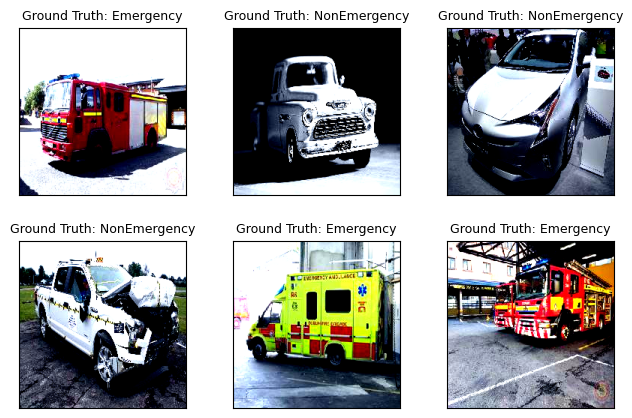

In [6]:
classes = ('Emergency', 'NonEmergency')

fig = plt.figure()

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    imgs = images[i] / 2 + 0.5 # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.title("Ground Truth: {}".format(classes[labels[i]]), fontsize=9)
    plt.xticks([])
    plt.yticks([])

# 4. Building the Network

*Next, we will define the Convolutional Neural Network (CNN) model that we will use for classifying emergency vehicles.*

The CNN architecture consists of multiple components. We begin with two convolutional layers, **conv1** and **conv2**, which perform feature extraction by applying a set of filters to the input images. The pooling layers, **pool1** and **pool2**, downsample the feature maps to retain the most salient information while reducing the spatial dimensions.

To prevent overfitting, we employ a **dropout** layer with a dropout rate of 0.3. This layer randomly masks out a portion of the neurons during training, forcing the network to learn more robust and generalizable representations.

Next, we introduce two fully connected layers, **fc1** and **fc2**, which process the flattened feature maps from the preceding convolutional layers. These layers perform the classification task by mapping the learned features to the output classes. 

Finally, we employ the **Flatten** layer to reshape the output of the pooling layers before passing it to the fully connected layers.

For training the model, we define the loss function as the Cross-Entropy Loss (nn.CrossEntropyLoss()) which is suitable for multi-class classification problems. 

In [7]:
# Define the CNN model
class EmergencyVehicleCNNClassifier(nn.Module):
    def __init__(self):
        super(EmergencyVehicleCNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=5, padding=2)
        self.pool1 = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(4, 4)
        self.dropout = nn.Dropout(p=0.3)
        self.fc1 = nn.Linear(14 * 16 * 14, 128)
        self.fc2 = nn.Linear(128, 2)
        self.flatten = nn.Flatten()  # new

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

To leverage the computing power of a GPU, we move the model to the GPU device 

In [8]:
# push the object into gpu by calling .to(device)
model = EmergencyVehicleCNNClassifier().to(device)

In [9]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)

# 5. Training the Model

During each epoch of training, we go through all the training data. To ensure the correct calculation of gradients, we start by manually setting the gradients to zero using the optimizer.zero_grad() function. This step is crucial because PyTorch, by default, accumulates gradients across multiple passes, and we want to compute fresh gradients for each batch.

Next, we pass the input data through our network and obtain the output predictions (forward pass). Using these predictions and the ground truth labels, we compute the negative log-likelihood loss. This loss measures the dissimilarity between the predicted probabilities and the true labels.

To update the network's parameters based on the computed gradients, we call the backward() function. This step allows us to collect a new set of gradients, which we then propagate back into each parameter of the network using the optimizer.step() function. By adjusting the parameters according to the computed gradients, the network learns to minimize the loss and improve its performance.

*To monitor the progress of our training process, we will include print statements at certain intervals to provide updates. These printouts will allow us to observe key information such as the current epoch, batch number, and training loss. This approach enables us to analyze the learning curve and assess the model's performance throughout the training process. The x-axis of the learning curve will represent the number of training examples processed by the network, providing valuable insights into the model's convergence and generalization capabilities.* 

In [10]:
train_losses = []
train_average_losses = []
train_counter = []
val_losses = []
val_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [11]:
def train(epoch):
    # ================================= Training =======================================
    model.train()
    train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(trainloader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Save individual loss
        if batch_idx % log_interval == 0:
            if verbose:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, 
                    batch_idx * len(inputs), 
                    len(trainloader.dataset),
                    100 * batch_idx / len(trainloader), 
                    loss.item()
                ))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(trainloader.dataset))
            )
        
        # Compute total loss for each epoch
        train_loss += loss.item()
    train_loss = train_loss / len(trainloader)
    train_average_losses.append(train_loss)
    
    return train_loss

In [12]:
def evaluate(epoch):
    # ================================= Evaluation =======================================
    model.eval()
    val_loss = 0.0
    n_correct = 0
    n_total = 0
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, pred = torch.max(outputs.data, 1)
            # Calculate number of correct prediction
            n_total += labels.size(0)
            n_correct += (pred == labels).sum().item()
    val_loss = val_loss / len(testloader)
    val_losses.append(val_loss)

    return val_loss, n_correct, n_total

In [13]:
for epoch in range(1, n_epochs+1):
    train_loss = train(epoch)
    val_loss, n_correct, n_total = evaluate(epoch)
    
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f} Accuracy: {}/{} ({:.0f}%)'
          .format(epoch, n_epochs, train_loss, val_loss, n_correct, n_total,
                  100. * n_correct / n_total))

Epoch [1/10], Train Loss: 0.5584, Val Loss: 0.4551 Accuracy: 319/413 (77%)
Epoch [2/10], Train Loss: 0.4484, Val Loss: 0.5050 Accuracy: 309/413 (75%)
Epoch [3/10], Train Loss: 0.3854, Val Loss: 0.4080 Accuracy: 334/413 (81%)
Epoch [4/10], Train Loss: 0.3124, Val Loss: 0.4098 Accuracy: 340/413 (82%)
Epoch [5/10], Train Loss: 0.2763, Val Loss: 0.3789 Accuracy: 335/413 (81%)
Epoch [6/10], Train Loss: 0.2498, Val Loss: 0.3817 Accuracy: 338/413 (82%)
Epoch [7/10], Train Loss: 0.1936, Val Loss: 0.3905 Accuracy: 343/413 (83%)
Epoch [8/10], Train Loss: 0.1444, Val Loss: 0.4563 Accuracy: 340/413 (82%)
Epoch [9/10], Train Loss: 0.1285, Val Loss: 0.4546 Accuracy: 340/413 (82%)
Epoch [10/10], Train Loss: 0.1337, Val Loss: 0.4622 Accuracy: 333/413 (81%)


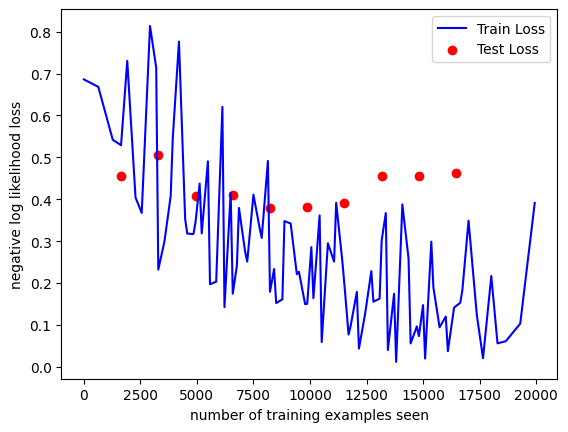

In [14]:
train_counter, train_losses = zip(*sorted(zip(train_counter, train_losses)))

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(val_counter[1:], val_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
plt.show()

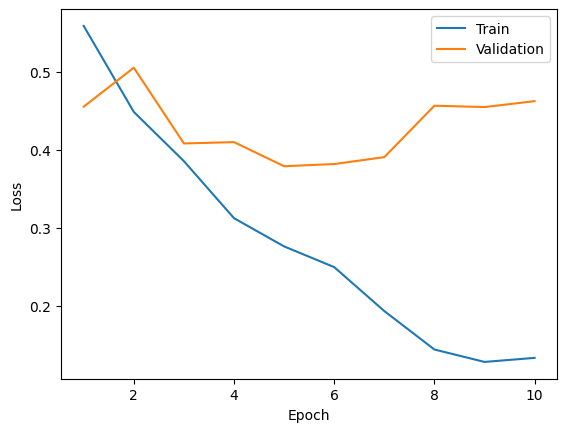

In [15]:
plt.plot(range(1, n_epochs+1), train_average_losses, label='Train')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 6. Predict

During prediction, we will load the trained model, and feed it through the model for inference. The model will analyze the input images and generate predictions based on the learned patterns and features. These predictions will indicate whether the given image represents an emergency vehicle or not.

In [16]:
images, labels = dataiter.next()

In [17]:
with torch.no_grad():
    output = model(images.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


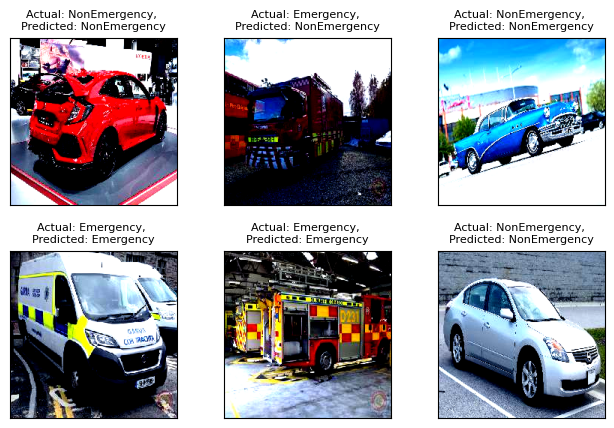

In [18]:
fig = plt.figure()

for i in range(6):
    predicted = classes[torch.max(output.data, 1)[1][i]]
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    imgs = images[i] / 2 + 0.5 # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.title("Actual: {}, \nPredicted: {}".format(classes[labels[i]], predicted), fontsize=8)
    plt.xticks([])
    plt.yticks([])

When predicting the first 6 images using our trained model, we observed that five of them were correctly classified. However, there was one instance, the second image, where the prediction did not match the ground truth label. In this case, the model incorrectly predicted the image as non-emergency while the actual label indicated it as an emergency vehicle.

Upon further analysis, we found that the high saturation level of the image could have influenced the prediction discrepancy. High saturation can sometimes lead to a distortion of color information, potentially affecting the model's ability to accurately classify the image.

## 7. Other setup: SGD Optimizer

SGD can be faster and more efficient for simple models or small datasets, while Adam may perform better for larger and more complex models or datasets with more noise and variability.

In [20]:
# Restart the model
model = EmergencyVehicleCNNClassifier().to(device)

In [21]:
train_losses = []
train_average_losses = []
train_counter = []
val_losses = []
val_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [22]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [23]:
for epoch in range(1, n_epochs+1):
    train_loss = train(epoch)
    val_loss, n_correct, n_total = evaluate(epoch)
    
    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f} Accuracy: {}/{} ({:.0f}%)'
          .format(epoch, n_epochs, train_loss, val_loss, n_correct, n_total,
                  100. * n_correct / n_total))

Epoch [1/10], Train Loss: 0.6699, Val Loss: 0.6670 Accuracy: 242/413 (59%)
Epoch [2/10], Train Loss: 0.6547, Val Loss: 0.6477 Accuracy: 243/413 (59%)
Epoch [3/10], Train Loss: 0.6362, Val Loss: 0.6272 Accuracy: 266/413 (64%)
Epoch [4/10], Train Loss: 0.6166, Val Loss: 0.6170 Accuracy: 259/413 (63%)
Epoch [5/10], Train Loss: 0.6004, Val Loss: 0.5893 Accuracy: 293/413 (71%)
Epoch [6/10], Train Loss: 0.5770, Val Loss: 0.5704 Accuracy: 288/413 (70%)
Epoch [7/10], Train Loss: 0.5618, Val Loss: 0.5560 Accuracy: 303/413 (73%)
Epoch [8/10], Train Loss: 0.5508, Val Loss: 0.5362 Accuracy: 300/413 (73%)
Epoch [9/10], Train Loss: 0.5365, Val Loss: 0.5319 Accuracy: 307/413 (74%)
Epoch [10/10], Train Loss: 0.5285, Val Loss: 0.5715 Accuracy: 291/413 (70%)


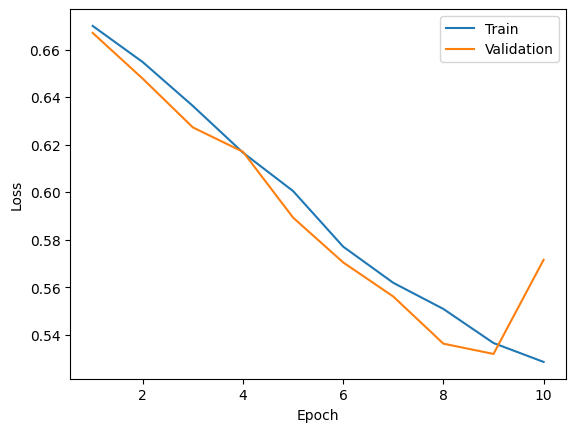

In [24]:
plt.plot(range(1, n_epochs+1), train_average_losses, label='Train')
plt.plot(range(1, n_epochs+1), val_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

From the plot, it is evident that the Adam optimizer outperforms the SGD optimizer in terms of training performance. The training loss decreases more rapidly and consistently with the Adam optimizer compared to the SGD optimizer. This indicates that the Adam optimizer is more effective in minimizing the loss and guiding the model towards convergence.

The disparity in performance between the two optimizers can be attributed to their underlying algorithms and optimization techniques. The Adam optimizer combines the advantages of both the adaptive learning rate method and momentum-based optimization, resulting in improved convergence and handling of varying learning rates. On the other hand, SGD relies solely on a fixed learning rate and momentum, which may limit its adaptability and effectiveness in certain scenarios.

## 7.1 Predict

In [25]:
with torch.no_grad():
    output = model(images.to(device))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


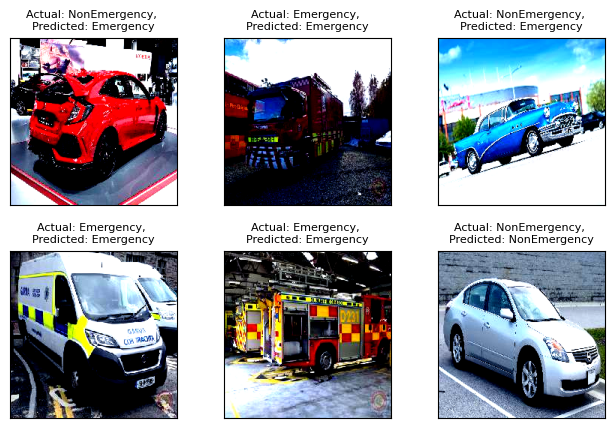

In [27]:
fig = plt.figure()

for i in range(6):
    predicted = classes[torch.max(output.data, 1)[1][i]]
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    imgs = images[i] / 2 + 0.5 # unnormalize
    npimgs = imgs.numpy()
    plt.imshow(np.transpose(npimgs, (1, 2, 0)))
    plt.title("Actual: {}, \nPredicted: {}".format(classes[labels[i]], predicted), fontsize=8)
    plt.xticks([])
    plt.yticks([])

When we used the trained CNN model optimized with SGD to predict a set of six similar images, we found that only four of them were correctly classified. However, there were two instances, specifically the first and third images, where the model's predictions did not match the ground truth labels.

# Conclusion

In conclusion, this project provided valuable insights into the process of training a Convolutional Neural Networks (CNNs) model for recognizing emergency vehicles. We embarked on a journey that involved various stages, including data preparation, model development, training, and evaluation. Throughout the project, we aimed to build an accurate and robust model capable of identifying emergency vehicles in real-world scenarios.

We designed and implemented a CNN architecture specifically tailored for the task of emergency vehicle recognition. This architecture consisted of convolutional layers for feature extraction, pooling layers for downsampling, dropout layers for regularization, and fully connected layers for classification. By constructing this model, we leveraged the power of deep learning to capture relevant patterns and discriminate between emergency and non-emergency vehicles.

During the training phase, we optimized the model's parameters using Adam & SGD optimizer and fine-tuned hyperparameters to enhance performance. The model demonstrated gradual improvement in accuracy as it learned to recognize critical features associated with emergency vehicles.

Our work showcased the power of deep learning in capturing complex patterns and highlighted the need for ongoing evaluation and improvement. By refining and optimizing the model, it holds great potential for real-world applications, contributing to the development of smart traffic systems that efficiently respond to emergency situations.